# Data Visualization

**Author**: Clarence Mah
<br>
**Last Updated**: 3/30/2023

We will demonstrate spatial visualization in `bento-tools` for exploring subcellular biology. We will explore the seqFISH+ 3T3 cells dataset, which we have included in the package.

## A Brief Overview

In `bento-tools` we provide a high-level interface based on [matplotlib](https://matplotlib.org/) for plotting spatial transcriptomics formatted as an `AnnData` object. [See more details about the data structure here.](../howitworks.md#data-structure) Data is represented as points and shapes, corresponding to molecules and segmentation masks. We closely mirror the [seaborn](http://seaborn.pydata.org/#) package for mapping data semantics, while replicating some [geopandas](https://geopandas.org/en/stable/) plotting functionality with styles more suitable for visualizing subcellular data. For spatial visualization at the tissue level (i.e. plotting cell coordinates instead of cell boundaries) we recommend using [squidpy](https://squidpy.readthedocs.io/en/stable/) and [scanpy](https://scanpy.readthedocs.io/en/stable/index.html) instead.

```{note}
In general, plotting in `bento-tools` assumes datasets will have data stored from multiple fields of view (fov), which must be encoded in `adata.obs["batch"]`. The plotting functions plot a single fov at a time, which can be set with the `batch` parameter; if unspecified, the default is inferred from the first cell in `adata`.

If available, cell and nuclear shapes are plotted by default. Plot more shape layers by passing their names in a list to the `shapes` parameter.
```

## Load Libraries and Data


In [1]:
import bento as bt
import matplotlib as mpl
import matplotlib.pyplot as plt

In [2]:
adata = bt.ds.load_dataset("seqfish")
adata

AnnData object with n_obs × n_vars = 211 × 9506
    obs: 'cell_shape', 'nucleus_shape', 'batch'
    uns: 'points'
    layers: 'spliced', 'unspliced'

## Plotting points

Let's plot the points (RNA) as a scatterplot in 2D. This is a lightweight wrapper around [sns.scatterplot](https://seaborn.pydata.org/generated/seaborn.scatterplot.html). Refer to the seaborn documentation for more details.


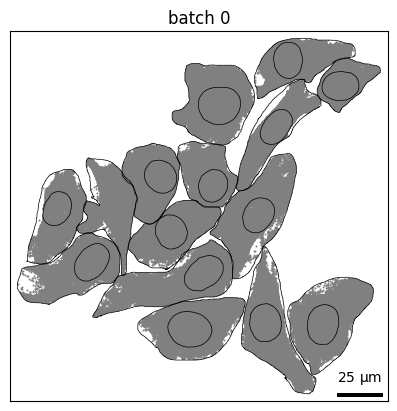

In [3]:
bt.pl.points(adata)

You can use `hue` to color transcripts by their gene identity. In this case there are >9000 genes, so it isn't very informative; you can also hide the legend with `legend=False`.


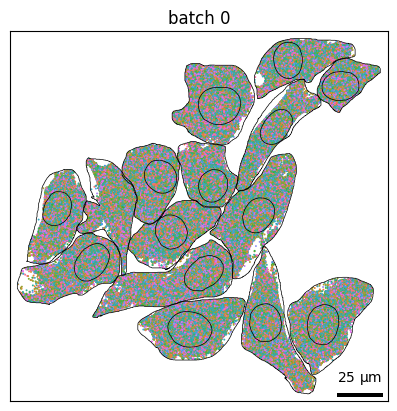

In [4]:
bt.pl.points(adata, hue="gene", legend=False)

If you have certain genes of interest, you can slice the `adata` object for that subset.


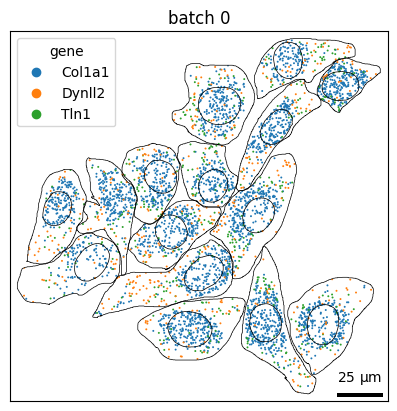

In [5]:
genes = ["Tln1", "Col1a1", "Dynll2"]
bt.pl.points(adata[:, genes], hue="gene")

## Plotting distributions

Often it may be more useful to look at how molecules are distributed rather than individual points. The `density()` function wraps `sns.histplot` and `sns.kdeplot`, which is specified with `kind='hist'` and `kind='kde'` respectively.

Plot 2D histogram of points:

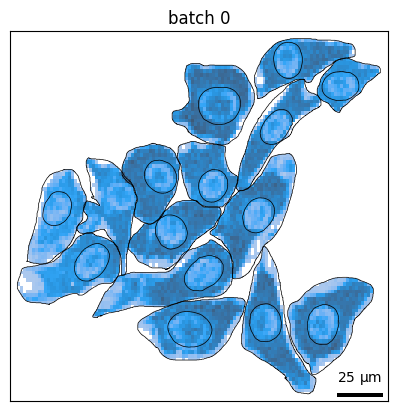

In [6]:
bt.pl.density(adata)

Plot 2D kernel density estimate of points:

```{note}
Density plots are not recommended for a large number of points; plotting will be extremely slow.
```

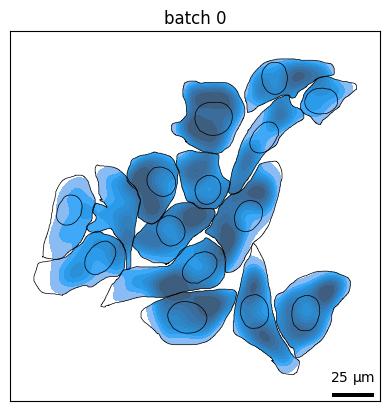

In [7]:
bt.pl.density(adata, kind="kde")

## Plotting shapes

For finer control over plotting shapes, you can use `bt.pl.shapes()`. Similar to above, cells and nuclei are shown by default. This function wraps the `geopandas` function `GeoDataFrame.plot()`.


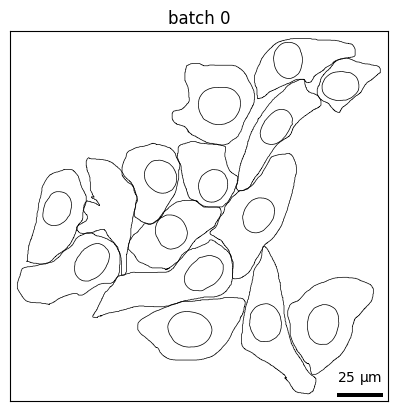

In [8]:
bt.pl.shapes(adata)

For convenience, `shapes()` provides two coloring styles, `color_style='outline'` (default) and `color_style='fill'`.


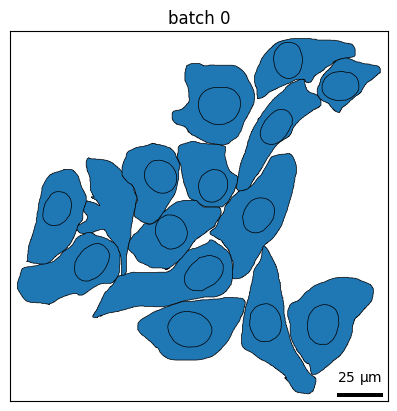

In [9]:
bt.pl.shapes(adata, color_style="fill")

You can use the `hue` parameter to color shapes by group e.g. cell, cell type, phenotype, etc.


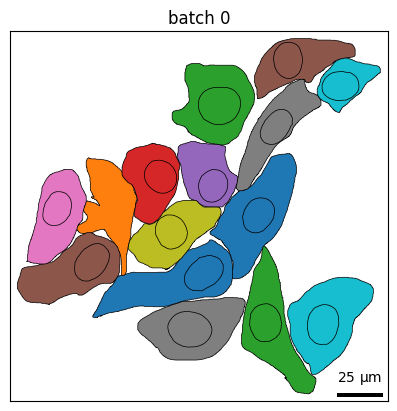

In [10]:
bt.pl.shapes(adata, hue="cell", color_style="fill")

You can also layer shapes on top of each other in the same plot. This allows you to style shapes differently; for example we can highlight the nucleus with color and the cell membrane with a dashed line.


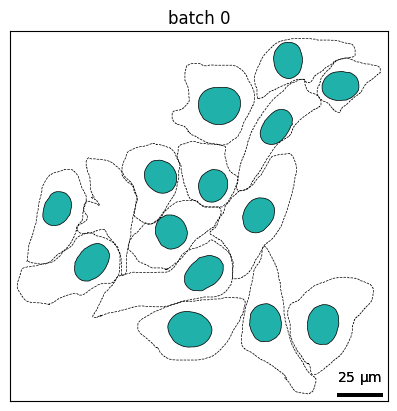

In [11]:
fig, ax = plt.subplots()
bt.pl.shapes(adata, shapes="cell", linestyle="--", ax=ax)
bt.pl.shapes(
    adata,
    shapes="nucleus",
    edgecolor="black",
    facecolor="lightseagreen",
    ax=ax,
)

## Figure aesthetics

To declutter unnecessary plot elements, you can use these convenient parameters:
- `axis_visible`: show/hide axis labels and ticks
- `frame_visible`: show/hide spines
- `square`: makes the plot square, useful for lining up multiple subplots
- `title`: defaults to the `batch` name, override with your own title

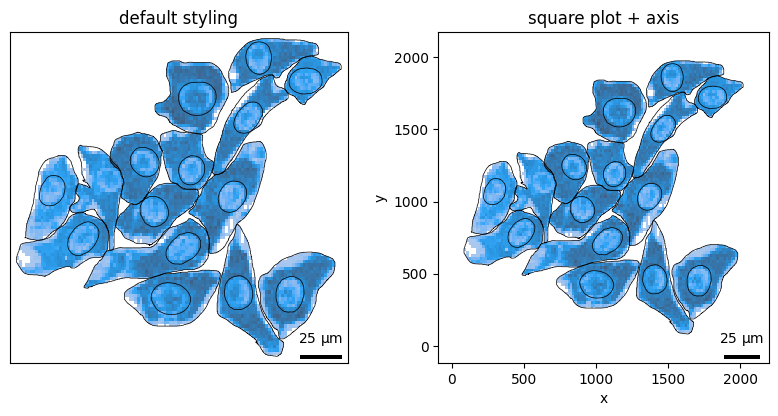

In [12]:
fig, axes = plt.subplots(1, 2, figsize=(8, 4))

bt.pl.density(adata, ax=axes[0], title="default styling")

bt.pl.density(
    adata,
    ax=axes[1],
    axis_visible=True,
    frame_visible=True,
    square=True,
    title="square plot + axis",
)
plt.tight_layout()

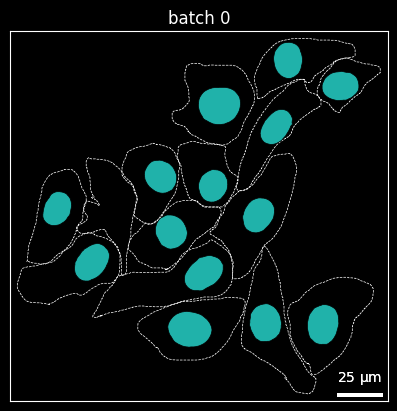

In [13]:
with mpl.style.context("dark_background"):
    fig, ax = plt.subplots()
    bt.pl.shapes(adata, shapes="cell", linestyle="--", ax=ax)
    bt.pl.shapes(
        adata,
        shapes="nucleus",
        edgecolor="black",
        facecolor="lightseagreen",
        ax=ax,
    )

## Building subplots

Since all plotting functions operate on `matplotlib.Axes` objects, not only can you build plots layer by layer, you can create multiple subplots.

You can tile across individual cells:

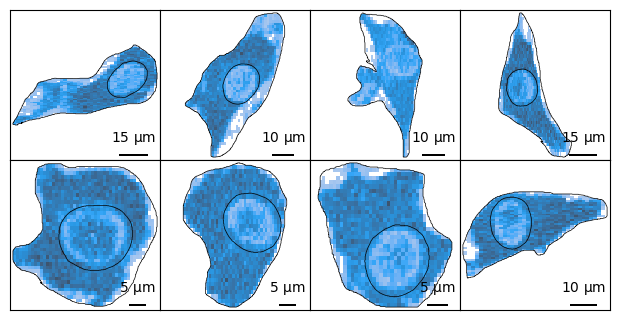

In [16]:
cells = adata.obs_names[:8]  # get some cells
ncells = len(cells)

ncols = 4
nrows = 2
ax_height = 1.5
fig, axes = plt.subplots(
    nrows, ncols, figsize=(ncols * ax_height, nrows * ax_height)
)  # instantiate

for c, ax in zip(cells, axes.flat):
    bt.pl.density(
        adata[c],
        ax=ax,
        square=True,
        title="",
    )

plt.subplots_adjust(wspace=0, hspace=0, bottom=0, top=1, left=0, right=1)

Or tile across each batch:

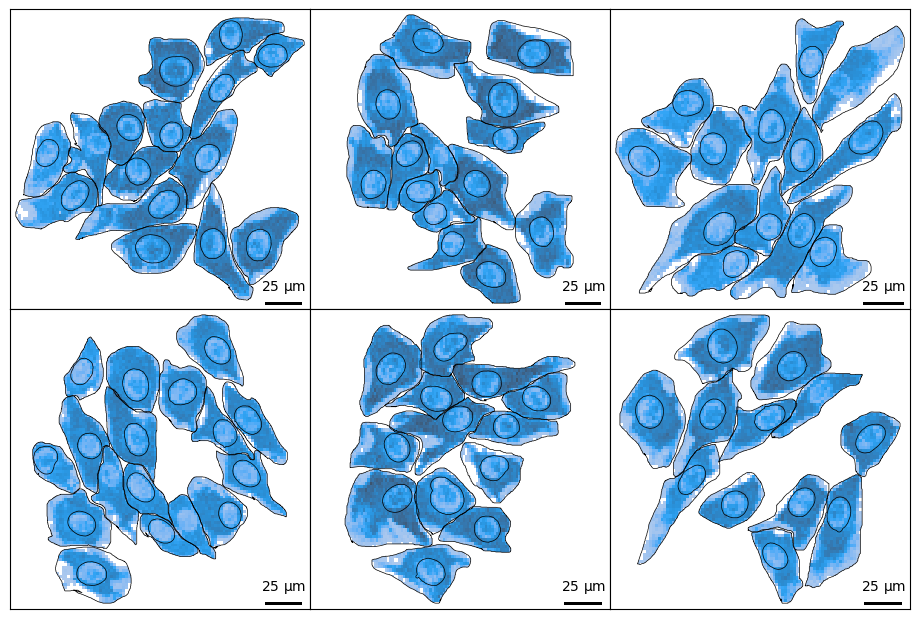

In [17]:
batches = adata.obs["batch"].unique()[:6]  # get 6 batches
nbatches = len(batches)

ncols = 3
nrows = 2
ax_height = 3
fig, axes = plt.subplots(
    nrows, ncols, figsize=(ncols * ax_height, nrows * ax_height)
)  # instantiate

for b, ax in zip(batches, axes.flat):
    bt.pl.density(
        adata,
        batch=b,
        ax=ax,
        square=True,
        title="",
    )

# remove empty axes
for ax in axes.flat[nbatches:]:
    ax.remove()

plt.subplots_adjust(wspace=0, hspace=0, bottom=0, top=1, left=0, right=1)